# GNN for Joint Link + Vote Prediction

This notebook trains a **Graph Neural Network (GraphSAGE)** to predict, for a pair *(voter u, candidate t)*:

- **Link existence**: will *u* vote on *t*? (`NoVote` vs `Voted`)
- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`

We model this as a **4-class edge classification** problem:
`{NoVote, Oppose, Neutral, Support}`.

Key implementation choices:
- **No leakage**: message passing uses only **training positive edges**.
- **Mini-batch training** with **LinkNeighborLoader**: each batch samples a subgraph around the queried links.
- **Negative sampling**: we create `NoVote` examples by sampling users who did **not** vote for the same candidate.

## Setup

In [1]:
# Import Packages
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import coalesce, remove_self_loops

## Data loading

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT) tuples.

In [2]:
print(f"Print first 10 lines of the dataset:")
printed = 0

# Load Dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()

        if printed < 10: 
            print(line)
            printed += 1

        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                samples.append((block["SRC"], block["TGT"], int(block["VOT"])))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"\nTotal samples: {len(samples)}")

Print first 10 lines of the dataset:
SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD

Total samples: 198275


## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [3]:
# Encode users as numerical IDs
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11381
[('', np.int64(0)), ('Stefan2', np.int64(9261)), ('Serviam', np.int64(8749)), ('DaffyDuckDied', np.int64(2356)), ('Bmills', np.int64(1319)), ('Delirium', np.int64(2607)), ('Nthep', np.int64(7151)), ('Starx', np.int64(9245)), ('Doidimais Brasil', np.int64(2770)), ('Mazca', np.int64(6293))]


In [4]:
def create_pyg_data(num_nodes, edge_index):
    x = torch.arange(num_nodes, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

In [5]:
# Dataset build (edge list + label)
X = []
y = []
for src, tgt, vot in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 198275


In [6]:
# Split positive edges into train/test and train/val
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos, test_size=0.2, random_state=42, stratify=y_pos)
X_tr_pos, X_val_pos, y_tr_pos, y_val_pos = train_test_split(X_train_pos, y_train_pos, test_size=0.1, random_state=42, stratify=y_train_pos)

print("Train+Val positive edges:", X_train_pos.size(0))
print("Train positive edges:", X_tr_pos.size(0))
print("Val positive edges:", X_val_pos.size(0))
print("Test positive edges:", X_test_pos.size(0))

Train+Val positive edges: 158620
Train positive edges: 142758
Val positive edges: 15862
Test positive edges: 39655


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

# Message-passing graph MUST contain only TRAIN POSITIVE edges (to avoid leakage)
train_edge_index = X_tr_pos.t().contiguous()  # [2, E_train_pos]
train_edge_index, _ = remove_self_loops(train_edge_index)
train_edge_index, _ = coalesce(train_edge_index, None, num_nodes=num_users)

data = create_pyg_data(num_users, train_edge_index)
print(f"Message-passing graph created with {data.num_nodes} nodes and {data.num_edges} edges")

Message-passing graph created with 11381 nodes and 137699 edges


## Negative sampling

Generate 'NoVote' negative examples for link prediction using candidate-centric sampling.

In [8]:
def build_voters_by_target(X_pos_tensor):
    # Return dict: target -> set(voters) for the given positive edges.
    voters = defaultdict(set)
    for u, t in X_pos_tensor.tolist():
        voters[int(t)].add(int(u))
    return voters

def sample_negatives_candidate_centric(X_pos_tensor, voters_by_target, num_nodes, neg_ratio=1, seed=42):
    # For each positive edge (u,t), sample neg_ratio pairs (u_neg, t) s.t. u_neg did NOT vote t.
    rng = random.Random(seed)
    targets = X_pos_tensor[:, 1].tolist()
    X_neg = []

    for t in targets:
        t = int(t)
        forbidden = voters_by_target[t]
        for _ in range(neg_ratio):
            while True:
                u_neg = rng.randrange(num_nodes)
                if u_neg not in forbidden:
                    X_neg.append([u_neg, t])
                    break

    return torch.tensor(X_neg, dtype=torch.long)

# Build voters-by-target maps for avoiding false negatives
voters_train = build_voters_by_target(X_tr_pos)
voters_val = build_voters_by_target(X_val_pos)
voters_test = build_voters_by_target(X_test_pos)

# Union map (train+val+test positives) to avoid sampling negatives that are actually positive somewhere
voters_all = defaultdict(set)
for d in (voters_train, voters_val, voters_test):
    for t, uset in d.items():
        voters_all[t].update(uset)

neg_ratio = 2  # 2

# Negatives for each split (no_vote = 0)
X_tr_neg = sample_negatives_candidate_centric(X_tr_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=42)
y_tr_neg = torch.zeros(X_tr_neg.size(0), dtype=torch.long)

X_val_neg = sample_negatives_candidate_centric(X_val_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=123)
y_val_neg = torch.zeros(X_val_neg.size(0), dtype=torch.long)

X_test_neg = sample_negatives_candidate_centric(X_test_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=999)
y_test_neg = torch.zeros(X_test_neg.size(0), dtype=torch.long)

# 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
X_tr_4 = torch.cat([X_tr_pos,  X_tr_neg],  dim=0)
y_tr_4 = torch.cat([y_tr_pos,  y_tr_neg],  dim=0)

X_val_4 = torch.cat([X_val_pos, X_val_neg], dim=0)
y_val_4 = torch.cat([y_val_pos, y_val_neg], dim=0)

X_test_4 = torch.cat([X_test_pos, X_test_neg], dim=0)
y_test_4 = torch.cat([y_test_pos, y_test_neg], dim=0)

print("Train 4-class size:", X_tr_4.size(0), " (pos:", X_tr_pos.size(0), "neg:", X_tr_neg.size(0), ")")
print("Val 4-class size:", X_val_4.size(0))
print("Test 4-class size:", X_test_4.size(0))

# Class weights for 4 classes (smoothed with alpha)
counts = torch.bincount(y_tr_4, minlength=4).float()
base_w = counts.sum() / (len(counts) * counts)
alpha = 0.5
class_weights = base_w.pow(alpha).to(device)

print("Train class counts [no_vote, oppose, neutral, support]:", counts.tolist())
print("Class weights:", class_weights.tolist())

Train 4-class size: 428274  (pos: 142758 neg: 285516 )
Val 4-class size: 47586
Test 4-class size: 118965
Train class counts [no_vote, oppose, neutral, support]: [285516.0, 29647.0, 9106.0, 104005.0]
Class weights: [0.6123724579811096, 1.9003801345825195, 3.4289963245391846, 1.0146207809448242]


## Neighbor-sampled loaders

Create LinkNeighborLoader objects to train on mini-batches using sampled subgraphs.

In [9]:
# LinkNeighborLoader
# Message passing happens on data.edge_index (TRAIN POS edges only)
train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_tr_4.t().contiguous(),
    edge_label=y_tr_4,
    batch_size=2048,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_val_4.t().contiguous(),
    edge_label=y_val_4,
    batch_size=4096,
    shuffle=False
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_test_4.t().contiguous(),
    edge_label=y_test_4,
    batch_size=4096,
    shuffle=False
)

## Model

Define the GraphSAGE encoder and edge-level decoder for 4-class (NoVote/Oppose/Neutral/Support) prediction.

In [10]:
class GNNVotePredictor(nn.Module):
    def __init__(self, num_nodes, emb_dim=64, hidden_dim=128, out_dim=4):
        """
        Args:
            num_nodes: Numero totale di utenti unici.
            emb_dim: Dimensione dell'embedding iniziale (learnable).
            hidden_dim: Dimensione delle feature nascoste della GNN.
            out_dim: Numero di classi di voto (-1, 0, 1) -> 3 classi.
        """
        super().__init__()
        
        # Sostituisce le features one-hot con vettori densi
        self.node_emb = nn.Embedding(num_nodes, emb_dim)
        
        # Graph layers
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        
        # Link Predictor
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, out_dim)
        )

    def forward(self, batch: Data):
        """
        Args:
            x: Input node features/IDs (tutti i nodi).
            edge_index: La struttura completa del grafo per il message passing.
            src_batch: Indici degli utenti votanti nel batch corrente.
            tgt_batch: Indici degli utenti candidati nel batch corrente.
        """
        # embedding iniziali solo per i nodi campionati
        x = self.node_emb(batch.n_id)
        
        # message passing on the subgraph
        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)

        # decode sui link del batch
        src, tgt = batch.edge_label_index  # indici locali
        h_src = x[src]
        h_tgt = x[tgt]

        # Concatena e classifica
        #edge_feat = torch.cat([h_src, h_tgt], dim=1)
        edge_feat = torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)
        return self.mlp(edge_feat)

In [11]:
model = GNNVotePredictor(num_nodes=num_users).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
class_weights = class_weights.to(device)

In [12]:
def eval_loader(loader):
    #Return macro-F1 (4-class) and link-F1 plus raw arrays
    model.eval()
    y_pred_all, y_true_all = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            pred = logits.argmax(dim=1).cpu()
            y_pred_all.append(pred)
            y_true_all.append(batch.edge_label.cpu())

    y_pred = torch.cat(y_pred_all).numpy()
    y_true = torch.cat(y_true_all).numpy()

    macro_f1 = f1_score(y_true, y_pred, average="macro")

    y_true_link = (y_true != 0).astype(int)
    y_pred_link = (y_pred != 0).astype(int)

    link_f1 = f1_score(y_true_link, y_pred_link, average="binary")

    return macro_f1, link_f1, y_true, y_pred

## Training

Train the model with weighted cross-entropy and early stopping on validation macro-F1.

In [13]:
# Training Loop
best_f1 = -1.0
best_state = None
patience = 5
bad_epochs = 0

for epoch in range(1, 51):
    model.train()
    total_loss, total_ex = 0.0 ,0
    
    for batch in train_loader:
        batch = batch.to(device)
    
        optimizer.zero_grad()
        out = model(batch)
        loss = F.cross_entropy(out, batch.edge_label, weight=class_weights)
        
        loss.backward()
        optimizer.step()

        bs = batch.edge_label.size(0)
        total_loss += loss.item() * bs
        total_ex += bs
    
    train_loss = total_loss / total_ex
    val_macro_f1, val_link_f1, _, _ = eval_loader(val_loader)

    print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1(4): {val_macro_f1:.4f} | Val link-F1: {val_link_f1:.4f}")

    if val_macro_f1 > best_f1 + 1e-4:
        best_f1 = val_macro_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping. Best Val macro-F1: {best_f1:.4f}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

Epoch 01 | Loss(avg): 1.1463 | Val macro-F1(4): 0.3434 | Val link-F1: 0.6077
Epoch 02 | Loss(avg): 0.9968 | Val macro-F1(4): 0.4724 | Val link-F1: 0.7286
Epoch 03 | Loss(avg): 0.9000 | Val macro-F1(4): 0.4892 | Val link-F1: 0.7578
Epoch 04 | Loss(avg): 0.8508 | Val macro-F1(4): 0.5053 | Val link-F1: 0.7797
Epoch 05 | Loss(avg): 0.8174 | Val macro-F1(4): 0.5113 | Val link-F1: 0.7887
Epoch 06 | Loss(avg): 0.7895 | Val macro-F1(4): 0.5170 | Val link-F1: 0.7937
Epoch 07 | Loss(avg): 0.7660 | Val macro-F1(4): 0.5435 | Val link-F1: 0.8043
Epoch 08 | Loss(avg): 0.7465 | Val macro-F1(4): 0.5462 | Val link-F1: 0.8109
Epoch 09 | Loss(avg): 0.7259 | Val macro-F1(4): 0.5615 | Val link-F1: 0.8195
Epoch 10 | Loss(avg): 0.7078 | Val macro-F1(4): 0.5692 | Val link-F1: 0.8270
Epoch 11 | Loss(avg): 0.6894 | Val macro-F1(4): 0.5853 | Val link-F1: 0.8342
Epoch 12 | Loss(avg): 0.6746 | Val macro-F1(4): 0.5855 | Val link-F1: 0.8356
Epoch 13 | Loss(avg): 0.6600 | Val macro-F1(4): 0.5791 | Val link-F1: 0.8336

Test macro-F1(4-class): 0.6173
Test link-F1 (existence): 0.8537

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.94      0.90      0.92     79310
      Oppose       0.45      0.62      0.52      8235
     Neutral       0.23      0.34      0.27      2530
     Support       0.76      0.75      0.75     28890

    accuracy                           0.83    118965
   macro avg       0.60      0.65      0.62    118965
weighted avg       0.85      0.83      0.84    118965



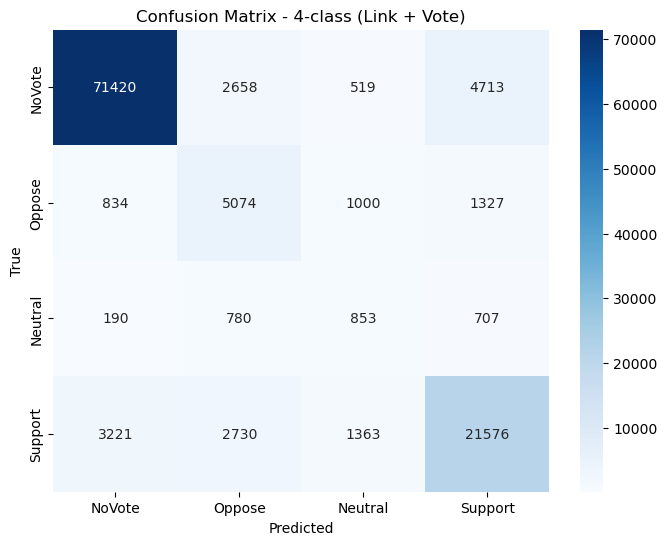


Link existence report (positive = voted):
              precision    recall  f1-score   support

      NoVote       0.94      0.90      0.92     79310
       Voted       0.82      0.89      0.85     39655

    accuracy                           0.90    118965
   macro avg       0.88      0.90      0.89    118965
weighted avg       0.90      0.90      0.90    118965


Vote polarity report on true-positive links (ignoring cases predicted as NoVote):
              precision    recall  f1-score   support

      Oppose       0.59      0.69      0.63      7401
     Neutral       0.27      0.36      0.31      2340
     Support       0.91      0.84      0.88     25669

    accuracy                           0.78     35410
   macro avg       0.59      0.63      0.61     35410
weighted avg       0.80      0.78      0.79     35410



In [14]:
# Final evaluation on TEST
test_macro_f1, test_link_f1, y_true, y_pred = eval_loader(test_loader)

print(f"Test macro-F1(4-class): {test_macro_f1:.4f}")
print(f"Test link-F1 (existence): {test_link_f1:.4f}")

print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
print(classification_report(
    y_true, y_pred,
    target_names=["NoVote", "Oppose", "Neutral", "Support"]
))

plt.figure(figsize=(8, 6))
cm4 = confusion_matrix(y_true, y_pred)
sns.heatmap(cm4, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NoVote", "Oppose", "Neutral", "Support"],
            yticklabels=["NoVote", "Oppose", "Neutral", "Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - 4-class (Link + Vote)")
plt.show()

# Link existence report (binary)
y_true_link = (y_true != 0).astype(int)
y_pred_link = (y_pred != 0).astype(int)
print("\nLink existence report (positive = voted):")
print(classification_report(y_true_link, y_pred_link, target_names=["NoVote", "Voted"]))

# Vote polarity report only on TRUE positives (where a vote exists)
mask_true_pos = (y_true != 0)
y_true_vote = y_true[mask_true_pos] - 1   # {1,2,3} -> {0,1,2}
y_pred_vote = y_pred[mask_true_pos] - 1   # may become -1 if predicted NoVote

mask_valid_pred = (y_pred_vote >= 0)
y_true_vote = y_true_vote[mask_valid_pred]
y_pred_vote = y_pred_vote[mask_valid_pred]

print("\nVote polarity report on true-positive links (ignoring cases predicted as NoVote):")
print(classification_report(
    y_true_vote, y_pred_vote,
    target_names=["Oppose", "Neutral", "Support"]
))